In [52]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Train data set

In [25]:
DATA_IN_PATH = './preprocessed_data/'
DATA_OUT = './data_out/'

In [26]:
TRAIN_Q1_DATA_FILE = 'q1_train.npy'
TRAIN_Q2_DATA_FILE = 'q2_train.npy'
TRAIN_LABEL_DATA_FILE = 'label_train.npy'
DATA_CONFIGS = 'data_configs.json'

In [27]:
train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# Modeling

In [28]:
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        self.conv = layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'],
                                  activation=tf.keras.activations.relu,
                                  padding='same')

        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)

        self.dense = layers.Dense(kargs['sent_embedding_dimension'], activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)

        return tf.squeeze(x, 1)

In [29]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        self.word_embedding = layers.Embedding(kargs['vocab_size'], kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'], activation=tf.keras.activations.relu)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = layers.Dropout(kargs['dropout_rate'])

    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)

        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)

        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)

        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)

        return self.logit(e_x)

# Model Hyper-parameters

In [30]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

In [31]:
kargs = {
    'model_name' : model_name,
    'vocab_size' : prepro_configs['vocab_size'],
    'word_embedding_dimension' : 100,
    'conv_num_filters' : 300,
    'conv_window_size' : 3,
    'max_pool_seq_len' : MAX_LEN,
    'sent_embedding_dimension' : 128,
    'dropout_rate' : 0.2,
    'hidden_dimension' : 200,
    'output_dimension' : 1
}

In [32]:
model = SentenceSimilarityModel(**kargs)

In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [47]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1, mode='max')

In [48]:
checkpoint_path = DATA_OUT+model_name+'/checkpoint.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [49]:
if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))

./data_out/cnn_similarity -- Folder already exists 



In [50]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True
)

In [51]:
history = model.fit((train_q1_data, train_q2_data), train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9152 - loss: 0.2080
Epoch 1: val_accuracy improved from -inf to 0.74663, saving model to ./data_out/cnn_similarity/checkpoint.weights.h5
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.9152 - loss: 0.2080 - val_accuracy: 0.7466 - val_loss: 0.6678
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9585 - loss: 0.1150
Epoch 2: val_accuracy improved from 0.74663 to 0.82735, saving model to ./data_out/cnn_similarity/checkpoint.weights.h5
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 130ms/step - accuracy: 0.9584 - loss: 0.1150 - val_accuracy: 0.8274 - val_loss: 0.5600
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9732 - loss: 0.0756
Epoch 3: val_accuracy did not improve from 0.82735
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - accuracy: 0.9732 - loss: 0.0756 - val_accuracy: 0.7714 - val_loss: 0.9365


# plot graph

In [53]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

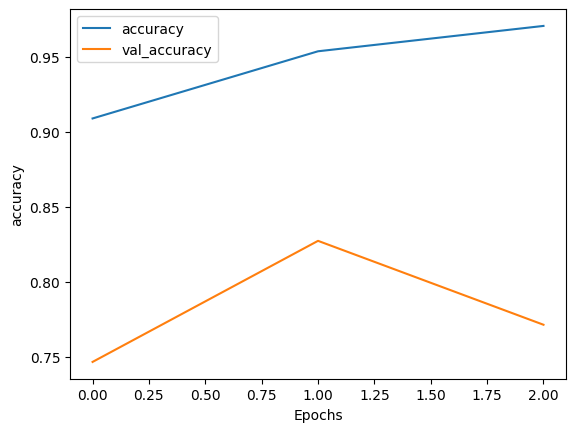

In [54]:
plot_graphs(history, 'accuracy')

# Evaluate Test Data

In [55]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

In [56]:
test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [57]:
SAVE_FILE_NM = 'checkpoint.weights.h5'

In [58]:
model.load_weights(os.path.join(DATA_OUT, model_name, SAVE_FILE_NM))

In [59]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step


In [60]:
predictions = predictions.squeeze(-1)

In [61]:
output = pd.DataFrame(data={'test_id' : test_id_data, 'is_duplicate': list(predictions)})

In [62]:
output.to_csv('cnn_predict.csv', index=False, quoting=3)